# Data

In [40]:
import geopandas as gpd
from shapely.geometry import box
from shapely.validation import make_valid
from pathlib import Path
import glob, os

# ==== Global settings ====
base_dir = r"G:/.shortcut-targets-by-id/1IxrYwiGiE0Nv92NbpTlq0AvOoDVNM35a/Inverst-health-city/City"
stat_dir = r"D:/natcap/invest-mental-health/data/data_desc"
base_folder = Path(base_dir)

# Vector data - risk prevelence

## clip function 

In [41]:
import geopandas as gpd
from shapely.geometry import box
from shapely.validation import make_valid
from pathlib import Path
import glob, os

def _ensure_valid_polys(gdf: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    gdf = gdf[gdf.geometry.notna() & ~gdf.geometry.is_empty].copy()
    gdf["geometry"] = gdf.geometry.apply(make_valid)
    gdf = gdf[gdf.geometry.notna() & ~gdf.geometry.is_empty]
    # keep polygon family only
    gdf = gdf[gdf.geom_type.isin(["Polygon", "MultiPolygon"])].copy()
    if len(gdf):
        # explode to single-part Polygons
        gdf = gdf.explode(index_parts=False, ignore_index=True)
        # after explode, everything should be Polygon; filter just in case
        gdf = gdf[gdf.geom_type.eq("Polygon")].copy()
    return gdf

def _remove_existing_shapefile(out_path: Path):
    pattern = str(out_path.with_suffix("")) + ".*"
    for f in glob.glob(pattern):
        try: os.remove(f)
        except OSError: pass

def clip_to_aoi_polygons_only(large_path, aoi_path, out_path, overwrite=True):
    large_path = Path(large_path)
    aoi_path = Path(aoi_path)
    out_path = Path(out_path)

    print("Reading…")
    src = gpd.read_file(large_path)
    aoi = gpd.read_file(aoi_path)

    print(f"Source: {len(src):,} | CRS={src.crs} | types={src.geom_type.unique()}")
    print(f"AOI:    {len(aoi):,} | CRS={aoi.crs} | types={aoi.geom_type.unique()}")

    if src.crs is None or aoi.crs is None:
        raise ValueError("Undefined CRS in inputs.")

    if src.crs != aoi.crs:
        print("Reprojecting AOI to match source CRS…")
        aoi = aoi.to_crs(src.crs)

    # if the source is not polygonal, warn (clip will return non-polys we then drop -> possibly empty)
    if not set(src.geom_type.unique()) & {"Polygon", "MultiPolygon"}:
        print("WARNING: Source isn’t polygonal; polygon-only output may be empty after filtering.")

    # bbox prefilter
    minx, miny, maxx, maxy = aoi.total_bounds
    idx = src.sindex.query(box(minx, miny, maxx, maxy), predicate="intersects")
    src_sub = src.iloc[idx].copy()
    print(f"Candidates for clipping: {len(src_sub):,} (of {len(src):,})")

    if len(src_sub) == 0:
        print("No candidates intersect AOI bbox.")
        return None

    print("Clipping…")
    clipped = gpd.clip(src_sub, aoi)

    print("Cleaning & enforcing polygons…")
    clipped = _ensure_valid_polys(clipped)
    print(f"Final polygons: {len(clipped):,}")

    if len(clipped) == 0:
        print("Nothing to write (no polygons).")
        return None

    out_path.parent.mkdir(parents=True, exist_ok=True)
    if overwrite and out_path.suffix.lower() == ".shp":
        _remove_existing_shapefile(out_path)

    print(f"Saving shapefile → {out_path}")
    clipped.to_file(out_path, driver="ESRI Shapefile")
    return clipped


## Clipping to AOI

Reading…
Source: 73,868 | CRS=EPSG:4269 | types=['Polygon' 'MultiPolygon']
AOI:    207 | CRS=EPSG:4269 | types=['Polygon' 'MultiPolygon']
Candidates for clipping: 336 (of 73,868)
Clipping…
Cleaning & enforcing polygons…
Final polygons: 217
Saving shapefile → D:\natcap\invest-mental-health\data\data_desc\prevalence_2021_boston.shp


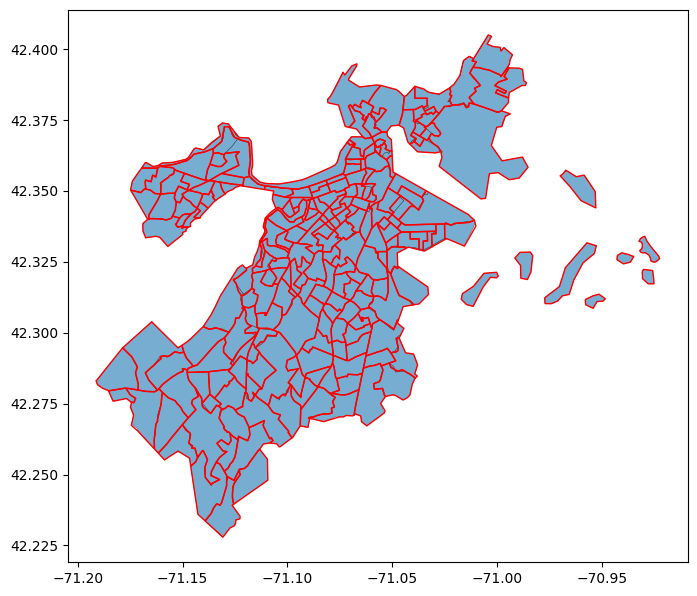

In [42]:
f_large = r"G:/Shared drives/invest-health/data/0_input_data/risk/prevalence_rate_usa_2021.shp"
f_aoi   = r"G:/.shortcut-targets-by-id/1IxrYwiGiE0Nv92NbpTlq0AvOoDVNM35a/Inverst-health-city/City/Boston/aoi_Boston.shp"
f_out   = r"D:/natcap/invest-mental-health/data/data_desc/prevalence_2021_boston.shp"

clipped_polys = clip_to_aoi_polygons_only(f_large, f_aoi, f_out, overwrite=True)
# quick view
if clipped_polys is not None:
    ax = clipped_polys.plot(figsize=(8,8), edgecolor="k", linewidth=0.3, alpha=0.6)
    gpd.read_file(f_aoi).boundary.plot(ax=ax, color="red", linewidth=1)


## data summary

In [43]:
## test script 
# 
# 
# import geopandas as gpd
# import pandas as pd
# import numpy as np
# from pathlib import Path
# from scipy import stats

# # Input shapefile path (output from previous clipping step)
# clipped_shp = Path(r"D:/natcap/invest-mental-health/data/data_desc/prevalence_2021_boston.shp")

# # Read clipped shapefile
# gdf = gpd.read_file(clipped_shp)

# # Ensure the "DEPRESS" column exists and is numeric
# if "DEPRESS" not in gdf.columns:
#     raise ValueError("'DEPRESS' column not found in the shapefile.")

# gdf["DEPRESS"] = pd.to_numeric(gdf["DEPRESS"], errors="coerce")

# # Drop NaN values
# values = gdf["DEPRESS"].dropna()

# # Calculate mean
# mean_val = values.mean()

# # Calculate standard error and 95% confidence interval
# n = len(values)
# if n > 1:
#     se = stats.sem(values, nan_policy="omit")
#     ci = stats.t.interval(0.95, df=n-1, loc=mean_val, scale=se)
# else:
#     se = np.nan
#     ci = (np.nan, np.nan)

# # Prepare results DataFrame
# results_df = pd.DataFrame({
#     "mean": [mean_val],
#     "CI_lower": [ci[0]],
#     "CI_upper": [ci[1]]
# })

# # Save to CSV
# output_csv = Path(r"D:/natcap/invest-mental-health/data/data_desc/prevalence_2021_boston_stats.csv")
# results_df.to_csv(output_csv, index=False)

# output_csv, results_df


## stats function for shp

In [44]:
import geopandas as gpd
import pandas as pd
import numpy as np
from pathlib import Path
from scipy.stats import t  # import directly to avoid shadowing issues

def calc_depress_stats(shp_path, out_csv_path=None, column="DEPRESS"):
    """
    Compute mean and 95% CI for a numeric column in a shapefile.
    Returns a 1-row DataFrame: file, n, mean, CI_lower, CI_upper.
    """
    shp_path = Path(shp_path)
    if out_csv_path is None:
        out_csv_path = shp_path.with_name(shp_path.stem + "_stats.csv")
    else:
        out_csv_path = Path(out_csv_path)

    gdf = gpd.read_file(shp_path)

    if column not in gdf.columns:
        raise ValueError(f"'{column}' not found in {shp_path}")

    # numeric conversion & drop NaNs
    vals = pd.to_numeric(gdf[column], errors="coerce").dropna().astype(float).to_numpy()
    n = vals.size

    if n == 0:
        mean_val, ci_low, ci_high = np.nan, np.nan, np.nan
    elif n == 1:
        mean_val, ci_low, ci_high = float(vals[0]), np.nan, np.nan
    else:
        mean_val = float(vals.mean())
        se = float(np.std(vals, ddof=1) / np.sqrt(n))
        tcrit = float(t.ppf(0.975, df=n-1))  # 95% CI
        ci_low = mean_val - tcrit * se
        ci_high = mean_val + tcrit * se

    result = pd.DataFrame([{
        "file": str(os.path.basename(shp_path)),
        "n": n,
        "mean": mean_val,
        "CI_lower": ci_low,
        "CI_upper": ci_high,
    }])

    # save per-file CSV
    out_csv_path.parent.mkdir(parents=True, exist_ok=True)
    result[["mean", "CI_lower", "CI_upper"]].to_csv(out_csv_path, index=False)
    # print(f"\n Saved stats to: {out_csv_path} \n")

    return result


## loop clip


In [45]:
import os
import pandas as pd



# ==== Loop through each city folder ====
for city in os.listdir(base_dir):
    city_folder = os.path.join(base_dir, city)
    if not os.path.isdir(city_folder):
        continue

    print(f"\n Processing: {city} ") 

    # Construct file paths
    aoi_path = os.path.join(city_folder, f"aoi_{city}.shp")
    # pop_path = os.path.join(city_folder, f"ppp_{city}.tif")
    # ndvi_path = os.path.join(city_folder, f"NDVI_median_landsat_30m_2021_{city}.tif")
    # tree_path = os.path.join(city_folder, f"treecover_{city}.tif")
    # output_dir = city_folder
    risk_clip_path = os.path.join(city_folder, f"prevalence_aoi_{city}.shp")

    ## clip shp 
    clip_to_aoi_polygons_only(f_large, aoi_path, risk_clip_path, overwrite=True)

    ## calculate statistics
    # stats = calc_depress_stats(risk_clip_path)
    # stats = calc_depress_stats(risk_clip_path, out_csv_path=None, column="DEPRESS")
    # print(stats)


 Processing: Seattle 
Reading…
Source: 73,868 | CRS=EPSG:4269 | types=['Polygon' 'MultiPolygon']
AOI:    178 | CRS=EPSG:4269 | types=['Polygon']
Candidates for clipping: 167 (of 73,868)
Clipping…
Cleaning & enforcing polygons…
Final polygons: 135
Saving shapefile → G:\.shortcut-targets-by-id\1IxrYwiGiE0Nv92NbpTlq0AvOoDVNM35a\Inverst-health-city\City\Seattle\prevalence_aoi_Seattle.shp

 Processing: Boston 
Reading…
Source: 73,868 | CRS=EPSG:4269 | types=['Polygon' 'MultiPolygon']
AOI:    207 | CRS=EPSG:4269 | types=['Polygon' 'MultiPolygon']
Candidates for clipping: 336 (of 73,868)
Clipping…
Cleaning & enforcing polygons…
Final polygons: 217
Saving shapefile → G:\.shortcut-targets-by-id\1IxrYwiGiE0Nv92NbpTlq0AvOoDVNM35a\Inverst-health-city\City\Boston\prevalence_aoi_Boston.shp

 Processing: Houston 
Reading…
Source: 73,868 | CRS=EPSG:4269 | types=['Polygon' 'MultiPolygon']
AOI:    929 | CRS=EPSG:4269 | types=['Polygon']
Candidates for clipping: 906 (of 73,868)
Clipping…
Cleaning & enfo

## loop stats

In [46]:
# ==== Loop through each city folder ====
# for city in os.listdir(base_dir):
#     city_folder = os.path.join(base_dir, city)
#     if not os.path.isdir(city_folder):
#         continue

#     print(f"\n Processing: {city} ") 

    
#     risk_clip_path = os.path.join(city_folder, f"prevalence_aoi_{city}.shp")

#     output_dir = city_folder

#     ## calculate statistics
#     stats = calc_depress_stats(risk_clip_path)
#     # print("\n")
#     print(stats)


from pathlib import Path
import pandas as pd

shps = list(base_folder.rglob("prevalence_aoi_*.shp"))  # recursive search
print(f"Found {len(shps)} shapefiles")


all_results = pd.concat(
    [calc_depress_stats(f) for f in shps],
    ignore_index=True
)

all_results.to_csv(
    os.path.join(stat_dir, "prevalence_aoi_stats.csv"),
    index=False
)

Found 15 shapefiles


# Raster data

## Functions for raster stats

In [47]:
from pathlib import Path
import numpy as np
import rasterio
from rasterio.transform import Affine
from scipy.stats import t  # import directly for CI

def _pixel_area_from_transform(transform: Affine) -> float:
    """Return pixel area in map units² for (possibly rotated) affine transforms."""
    return abs(transform.a * transform.e - transform.b * transform.d)

def mean_continuous_raster(
    raster_path: str | Path,
    band: int = 1,
    return_ci95: bool = True,
    extra_nodata_values: tuple = (254, 255)  # extra invalid values for tree cover
):
    """
    Compute descriptive stats for a continuous single-band raster (e.g., tree cover %, NDVI).

    Notes:
      * extra_nodata_values allows adding specific codes to mask (e.g., 254, 255).
      * Returns dictionary with mean, std, min, max, sum, counts, pixel_area, total_area, crs.
    """
    raster_path = Path(raster_path)
    with rasterio.open(raster_path) as ds:
        if ds.count < band:
            raise ValueError(f"Band {band} not found in {raster_path}")

        nodata = ds.nodata
        nodata_is_nan = isinstance(nodata, float) and np.isnan(nodata)

        try:
            scale = ds.scales[band-1] if ds.scales and ds.scales[band-1] is not None else 1.0
        except Exception:
            scale = 1.0
        try:
            offset = ds.offsets[band-1] if ds.offsets and ds.offsets[band-1] is not None else 0.0
        except Exception:
            offset = 0.0

        px_area = _pixel_area_from_transform(ds.transform)
        crs = str(ds.crs) if ds.crs else None

        n_valid = 0
        n_total = 0
        s1 = 0.0
        s2 = 0.0
        vmin = np.inf
        vmax = -np.inf

        for _, window in ds.block_windows(band):
            data = ds.read(band, window=window, masked=False)

            # Build mask: numeric NoData and/or NaN
            if nodata is None or nodata_is_nan:
                mask = np.isnan(data)
            else:
                mask = (data == nodata) | np.isnan(data)

            # Mask explicit extra_nodata_values (like 254, 255)
            if extra_nodata_values:
                mask |= np.isin(data, extra_nodata_values)

            # Combine with explicit mask band if available (0 = invalid)
            try:
                mask_band = ds.read_masks(band, window=window)
                mask |= (mask_band == 0)
            except Exception:
                pass

            valid = ~mask
            n = int(valid.sum())
            n_total += data.size
            if n == 0:
                continue

            vals = data.astype("float64", copy=False)
            vals = vals * float(scale) + float(offset)
            vals = np.where(valid, vals, np.nan)
            vals = np.nan_to_num(vals, nan=0.0)

            n_valid += n
            s1 += vals.sum(dtype=np.float64)
            s2 += (vals * vals).sum(dtype=np.float64)

            vmin = min(vmin, vals[valid].min())
            vmax = max(vmax, vals[valid].max())

        if n_valid == 0:
            result = {
                "n_total_pixels": n_total,
                "n_valid_pixels": 0,
                "nodata": nodata,
                "scale": scale,
                "offset": offset,
                "mean": np.nan,
                "std": np.nan,
                "min": np.nan,
                "max": np.nan,
                "sum": 0.0,
                "pixel_area": px_area,
                "total_area_valid": 0.0,
                "crs": crs,
            }
            if return_ci95:
                result.update({"ci95_low": np.nan, "ci95_high": np.nan})
            return result

        mean = s1 / n_valid
        if n_valid >= 2:
            var = max(0.0, (s2 - n_valid * (mean ** 2)) / (n_valid - 1))
            std = np.sqrt(var)
        else:
            std = np.nan

        result = {
            "n_total_pixels": n_total,
            "n_valid_pixels": n_valid,
            "nodata": nodata,
            "scale": scale,
            "offset": offset,
            "mean": float(mean),
            "std": float(std),
            "min": float(vmin),
            "max": float(vmax),
            "sum": float(s1),
            "pixel_area": float(px_area),
            "total_area_valid": float(px_area * n_valid),
            "crs": crs,
        }

        if return_ci95:
            if n_valid >= 2 and np.isfinite(std):
                se = std / np.sqrt(n_valid)
                tcrit = float(t.ppf(0.975, df=n_valid - 1))
                result["ci95_low"] = float(mean - tcrit * se)
                result["ci95_high"] = float(mean + tcrit * se)
            else:
                result["ci95_low"] = np.nan
                result["ci95_high"] = np.nan

        return result


## Tree cover and NDVI


### Tree cover
Pixel values range from 0 to 100 percent. The non-processing area is represented by value 254, and the background is represented by the value 255.

In [48]:
from pathlib import Path
import pandas as pd

base_path = Path(base_dir)
out_csv  = Path(os.path.join(stat_dir, 'treecover_stats.csv'))

rows = []
for city_dir in sorted([p for p in base_path.iterdir() if p.is_dir()]):
    # Adjust pattern to your filenames, e.g., "treecover.tif" or "ndvi.tif"
    candidates = list(city_dir.glob("treecover_*_prj_clipped.tif"))
    if not candidates:
        print(f"Skip (no raster): {city_dir.name}")
        continue
    r = mean_continuous_raster(candidates[0], band=1,
                               extra_nodata_values=(254, 255),  # extra invalid values for tree cover
                               return_ci95=True)
    rows.append({"city": city_dir.name, "raster_path": str(candidates[0]), **r})
    print(f"OK: {city_dir.name} → mean={r['mean']:.4f} (n={r['n_valid_pixels']})")

df = pd.DataFrame(rows)
out_csv.parent.mkdir(parents=True, exist_ok=True)
df.to_csv(out_csv, index=False)
print(f"Saved → {out_csv}")


OK: Boston → mean=19.1320 (n=151181)
OK: Chicago → mean=6.6194 (n=689072)
OK: Denver → mean=6.3666 (n=445182)
OK: Detroit → mean=10.6501 (n=410897)
OK: Houston → mean=18.0397 (n=3366391)
OK: Los_Angeles → mean=8.6754 (n=1376053)
OK: Miami → mean=7.1905 (n=151345)
OK: Minneapolis → mean=15.6860 (n=165466)
OK: New_York → mean=11.7904 (n=976826)
OK: Philadelphia → mean=16.5345 (n=410639)
OK: Phoenix → mean=0.7779 (n=1801786)
OK: San_Antonio → mean=12.9889 (n=2410208)
OK: San_Diego → mean=7.4330 (n=1212901)
OK: San_Francisco → mean=6.8293 (n=136067)
OK: Seattle → mean=20.3831 (n=290037)
Saved → D:\natcap\invest-mental-health\data\data_desc\treecover_stats.csv


### NDVI

In [49]:
out_csv  = Path(os.path.join(stat_dir, 'ndvi_stats.csv'))

rows = []
for city_dir in sorted([p for p in base_path.iterdir() if p.is_dir()]):
    # Adjust pattern to your filenames, e.g., "treecover.tif" or "ndvi.tif"
    candidates = list(city_dir.glob("NDVI_median_landsat_30m_2021_*_prj_clipped.tif"))
    # candidates = list(city_dir.glob("ndvi_masked.tif")) ## mask out ndvi < 0, with resolution of 100 m 
    if not candidates:
        print(f"Skip (no raster): {city_dir.name}")
        continue
    r = mean_continuous_raster(candidates[0], band=1,
                               extra_nodata_values=(999, 255),  # extra invalid values for NDVI
                               return_ci95=True)
    rows.append({"city": city_dir.name, "raster_path": str(candidates[0]), **r})
    print(f"OK: {city_dir.name} → mean={r['mean']:.4f} (n={r['n_valid_pixels']})")

df = pd.DataFrame(rows)
out_csv.parent.mkdir(parents=True, exist_ok=True)
df.to_csv(out_csv, index=False)
print(f"Saved → {out_csv}")

OK: Boston → mean=0.1212 (n=736515)
OK: Chicago → mean=0.1059 (n=2429171)
OK: Denver → mean=0.0776 (n=2277928)
OK: Detroit → mean=0.1851 (n=1297450)
OK: Houston → mean=0.2426 (n=7956543)
OK: Los_Angeles → mean=0.1081 (n=4050208)
OK: Miami → mean=0.1232 (n=416222)
OK: Minneapolis → mean=0.3134 (n=273237)
OK: New_York → mean=0.1059 (n=3249522)
OK: Philadelphia → mean=0.1629 (n=1199561)
OK: Phoenix → mean=0.0834 (n=4260395)
OK: San_Antonio → mean=0.2432 (n=5318624)
OK: San_Diego → mean=0.1069 (n=3789350)
OK: San_Francisco → mean=0.0341 (n=1554136)
OK: Seattle → mean=0.2226 (n=709306)
Saved → D:\natcap\invest-mental-health\data\data_desc\ndvi_stats.csv


## preventable cases & cost

### functions

In [50]:
from pathlib import Path
import pandas as pd
import numpy as np
import rasterio

def sum_continuous_raster(raster_path: Path):
    """
    Return total population and basic metadata from a single-band population raster.
    - Handles NoData as numeric nodata and/or NaN
    - Uses the mask band if present
    - Processes by blocks to avoid large-memory reads
    - Applies scale/offset if present (value = raw*scale + offset)
    """
    raster_path = Path(raster_path)
    with rasterio.open(raster_path) as ds:
        if ds.count < 1:
            raise ValueError(f"No bands found in {raster_path}")

        nodata = ds.nodata
        nodata_is_nan = isinstance(nodata, float) and np.isnan(nodata)

        # Grab scale/offset if defined (often 1/0)
        try:
            scale = ds.scales[0] if ds.scales and ds.scales[0] is not None else 1.0
        except Exception:
            scale = 1.0
        try:
            offset = ds.offsets[0] if ds.offsets and ds.offsets[0] is not None else 0.0
        except Exception:
            offset = 0.0

        total = 0.0
        n_valid = 0
        n_total = 0

        for _, window in ds.block_windows(1):
            data = ds.read(1, window=window, masked=False)

            # Mask creation
            if nodata is None:
                mask = np.isnan(data)
            else:
                if nodata_is_nan:
                    mask = np.isnan(data)
                else:
                    mask = (data == nodata) | np.isnan(data)

            # Combine with explicit mask band (0 = invalid)
            try:
                mask_band = ds.read_masks(1, window=window)
                mask |= (mask_band == 0)
            except Exception:
                pass

            valid = ~mask
            n_valid += int(valid.sum())
            n_total += data.size

            if valid.any():
                # Ensure float for safe accumulation
                valid_vals = np.where(valid, data.astype("float64", copy=False), 0.0)
                valid_vals = np.nan_to_num(valid_vals, nan=0.0)
                total += valid_vals.sum(dtype=np.float64)

        # Apply scale/offset: value = raw*scale + offset (per pixel)
        total = total * float(scale) + float(offset) * n_valid

        return {
            "n_total_pixels": n_total,
            "n_valid_pixels": n_valid,
            "nodata": nodata,
            "scale": scale,
            "offset": offset,
            "total_value": float(total),
        }
    


    

def find_city_raster(city_dir: Path, patterns=("*.tif", "*pop*.tif", "*population*.tif")) -> Path | None:
    """
    Find a population raster in a city folder.
    You can customize patterns to be stricter, e.g., ("population.tif",).
    Returns first match (depth-first). None if not found.
    """
    for pat in patterns:
        hits = list(city_dir.glob(pat))
        if hits:
            # Prefer names containing 'pop' or 'population' if multiple
            hits_sorted = sorted(hits, key=lambda p: (("population" not in p.stem.lower()) and ("pop" not in p.stem.lower()), p.name.lower()))
            return hits_sorted[0]
    return None

def sum_by_city(base_dir: str | Path,
                             combined_csv: str | Path,
                             raster_patterns=("population.tif", "*population*.tif", "*pop*.tif", "*.tif")) -> pd.DataFrame:
    """
    Walk `base_dir`/<city>/..., sum population from a raster per city, and save one CSV.
    """
    base_dir = Path(base_dir)
    combined_csv = Path(combined_csv)
    rows = []

    for city_path in sorted([p for p in base_dir.iterdir() if p.is_dir()]):
        city = city_path.name
        raster_path = find_city_raster(city_path, patterns=raster_patterns)
        if raster_path is None:
            print(f"Skip (no raster found): {city}")
            continue

        try:
            stats = sum_continuous_raster(raster_path)
            rows.append({
                "city": city,
                "raster_path": str(raster_path),
                **stats
            })
            print(f"OK: {city} → total={stats['total_value']:.2f}, valid_px={stats['n_valid_pixels']}")
        except Exception as e:
            print(f"Error processing {city} ({raster_path}): {e}")

    if not rows:
        print("No results to save.")
        return pd.DataFrame()

    df = pd.DataFrame(rows)
    combined_csv.parent.mkdir(parents=True, exist_ok=True)
    df.to_csv(combined_csv, index=False)
    print(f"\nSaved combined totals → {combined_csv}")
    return df


### run 

In [51]:

df_case = sum_by_city(
    base_dir=base_dir,
    combined_csv=os.path.join(stat_dir, 'Prev_case_stats.csv'),
    raster_patterns=("Prev_case.tif",)
)

df_cost = sum_by_city(
    base_dir=base_dir,
    combined_csv=os.path.join(stat_dir, 'Prev_cost_stats.csv'),
    raster_patterns=("Prev_cost_pixel.tif",)
)


OK: Boston → total=243581.31, valid_px=3050
OK: Chicago → total=1409788.56, valid_px=33706
OK: Denver → total=260160.21, valid_px=9423
OK: Detroit → total=81221.01, valid_px=8282
OK: Houston → total=487989.26, valid_px=27046
OK: Los_Angeles → total=3022811.33, valid_px=69818
Skip (no raster found): Miami
OK: Minneapolis → total=70516.36, valid_px=1974
OK: New_York → total=8675256.48, valid_px=49136
OK: Philadelphia → total=1338640.81, valid_px=14967
OK: Phoenix → total=2261809.91, valid_px=75657
OK: San_Antonio → total=190207.62, valid_px=14114
OK: San_Diego → total=838133.82, valid_px=31665
OK: San_Francisco → total=1173968.78, valid_px=13173
OK: Seattle → total=137816.17, valid_px=3370

Saved combined totals → D:\natcap\invest-mental-health\data\data_desc\Prev_case_stats.csv
OK: Boston → total=2679394.45, valid_px=3050
OK: Chicago → total=15507674.21, valid_px=33706
OK: Denver → total=2861762.31, valid_px=9423
OK: Detroit → total=893431.14, valid_px=8282
OK: Houston → total=5367881.8